# Data Cleaning, Manipulation and Visualisations

This notebook contains the software used for creating JSON files for the covid webgl globe cases, NO2 and carbon emission plots and image generation for use as basemaps on the globe. 

#### Data Cleaning and conversion to JSON

In [3]:
import json
import pandas as pd
import math

Only relevant data is selected from the file. The cases are converted to fit a logarithmic scale to ensure that columns on the webgl globe are more easily differentiable throughout the selected timeline.

In [92]:
# Pandas data
df = pd.read_csv('./COVID-19-Data-Europe-with-geotags.csv', usecols=['Latitude','Longitude','date','total_cases','total_deaths'])
lat = df['Latitude']
lon = df['Longitude']
date = df['date']
cases1 = df['total_cases']
#deaths = df['total_deaths']

# Convert to logarithmic scale
cases = []
maxCase = max(cases1)
for item in cases1:
    cases.append(math.log(1+item)/math.log(1+maxCase))

Each case from the data is added to the dataCases dictionary with the date as the key.

In [94]:
dataCases = {}
dateSet = set()
for date,lat,lon,case in zip(date, lat, lon, cases): 
    if date[2:4] == '20' and not math.isnan(lat):
        #print(date,lat,lon,case,death)
        if date not in dateSet:
            dateSet.add(date)
            dataCases[date] = []
        dataCases[date].append(lat)
        dataCases[date].append(lon)
        dataCases[date].append(case)

The dataCases dictionary is converted to the format required for displaying columns on the webgl globe. The current format is JSON, with separate arrays for each series (date).

In [95]:
jsonfile = []
for day in dataCases:
    jsonfile.append([day, dataCases[day]])
with open('data.txt', 'w') as outfile:
    json.dump(jsonfile, outfile)

## Graphs of NO2 and Carbon for Europe Region

In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# NO2 and Carbon data source - data not included due to size
fh = Dataset('adaptor.cams_regional_fc.retrieve-1590942035.0237532-6421-6-c865e827-a2d1-4a26-9930-2822810a1507.nc', mode='r')
no2 = fh.variables['no2_conc'][:]
carbon = fh.variables['ecff_conc'][:]
lats = fh.variables['latitude'][:]
lons = np.array([(((item+180) % 360) -180) for item in fh.variables['longitude'][:]])

print(fh.variables['no2_conc'])
print(fh.variables['ecff_conc'])

fh.close()

<class 'netCDF4._netCDF4.Variable'>
float32 no2_conc(time, level, latitude, longitude)
    _FillValue: -999.0
    species: Nitrogen Dioxide
    units: µg/m3
    value: hourly values
    standard_name: mass_concentration_of_nitrogen_dioxide_in_air
unlimited dimensions: time
current shape = (151, 3, 373, 619)
filling on
<class 'netCDF4._netCDF4.Variable'>
float32 ecff_conc(time, level, latitude, longitude)
    _FillValue: -999.0
    species: PM2.5 Elemental Carbon from Anthropogenic Fossil Fuels
    units: µg/m3
    value: hourly values
    standard_name: Not Defined
unlimited dimensions: time
current shape = (151, 3, 373, 619)
filling on


#### NO2 Plot Examples 'Days' are numbered from January 1 2020 (Day 1)

C:\Users\owen3\anaconda3\envs\Data\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
C:\Users\owen3\anaconda3\envs\Data\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\owen3\anaconda3\envs\Data\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


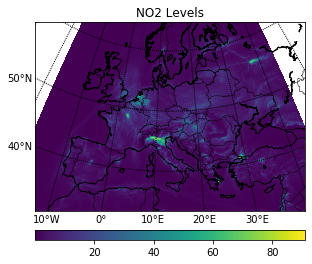

In [31]:
DAY = 10

# Parameters for a Stereographic Projection
lon_0 = lons.mean()
lat_0 = lats.mean()

m = Basemap(width=5000000,height=3500000,
            resolution='l',projection='stere',\
            lat_ts=40,lat_0=lat_0,lon_0=lon_0)

lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

cs = m.pcolor(xi,yi,np.squeeze(no2[DAY][0]))

# Grid Lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1])

# Add Borders, Countries and Coastlines
m.drawcoastlines()
m.drawstates()
m.drawcountries()

cbar = m.colorbar(cs, location='bottom', pad="10%")

plt.title('NO2 Levels')
plt.show()

# NO2 Images for Globe Basemap
The below cell was used to generate the images for the NO2 emissions in the Europe. Images are saved as pngs with no bounding box or padding. The DPI can be changed to suit the requirements, however low DPI is not recommended due to severe blurring and loss of data when displayed on the webgl globe.

C:\Users\owen3\anaconda3\envs\Data\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
C:\Users\owen3\anaconda3\envs\Data\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()
C:\Users\owen3\anaconda3\envs\Data\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


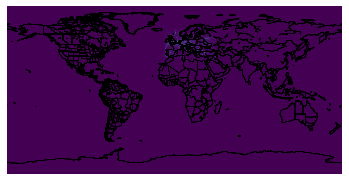

In [45]:
for DAY in range(1,30,2):
    
    m = Basemap(width=5000000, height=3500000, resolution='l')

    lon, lat = np.meshgrid(lons, lats)
    xi, yi = m(lon, lat)

    # Optional Grid Lines for Image
    #m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
    #m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

    # Add Borders, Countries and Coastlines

    m.drawstates(linewidth=0.25)
    m.drawcountries(linewidth=0.25)
    m.drawcoastlines(linewidth=0.25)
    m.drawmapboundary(color='#440154',fill_color='#440154')

    # Data Layer
    cs = m.pcolor(xi,yi,np.squeeze(no2[DAY+121][0]))

    name = 'worldNO22020-05-{:02d}'.format(DAY)
    plt.axis('off')
    plt.savefig(name, bbox_inches='tight', dpi=1000, pad_inches=0)#plt.show()
    

### A sidenote on how to obtain the background color of the pcolor function

In [36]:
import matplotlib
cmap = matplotlib.cm.get_cmap('viridis') # Viridis is the cmap used by default

rgba = cmap(0, bytes=True) # Cmap values range between 0 and 1
print(rgba)

(68, 1, 84, 255)


# Carbon Plots

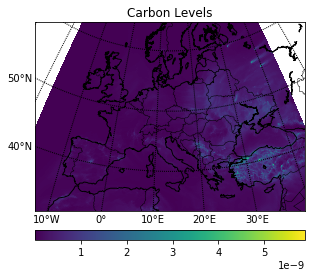

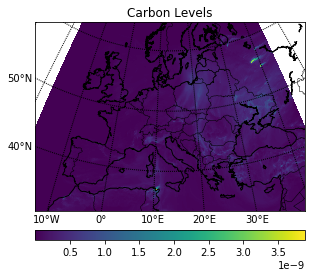

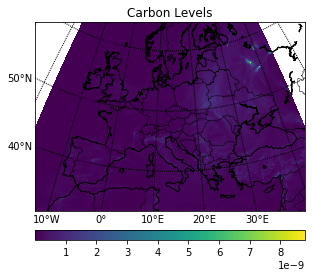

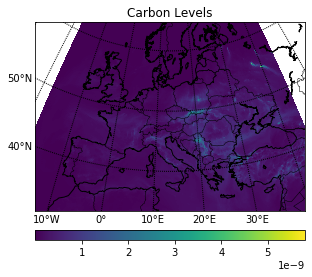

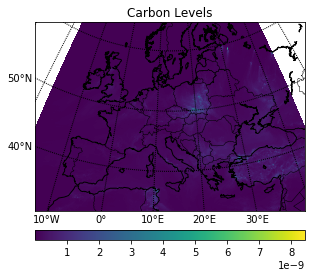

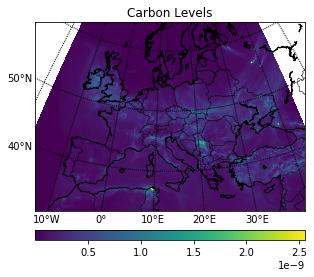

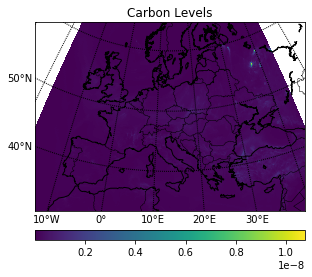

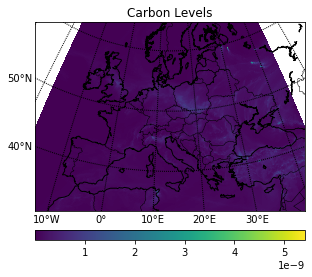

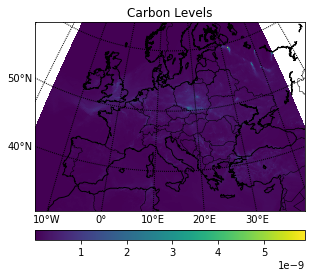

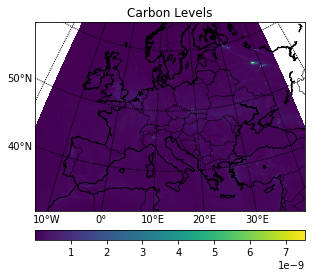

In [100]:
for day in range(50,150,10):
    cs = m.pcolor(xi,yi,np.squeeze(carbon[day][0]))

    # Grid Lines
    m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

    # Add Borders, Countries and Coastlines
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()

    cbar = m.colorbar(cs, location='bottom', pad="10%")

    plt.title('Carbon Levels')
    plt.show()